In [1]:
import numpy as np
import pandas as pd
import bagpipes as bp
import math
import os

In [2]:
filter_list_splus = ['filters/uJAVA.dat',
                     'filters/F0378.dat',
                     'filters/F0395.dat',
                     'filters/F0410.dat',
                     'filters/F0430.dat',
                     'filters/gSDSS.dat',
                     'filters/F0515.dat',
                     'filters/rSDSS.dat',
                     'filters/F0660.dat',
                     'filters/iSDSS.dat',
                     'filters/F0861.dat',
                     'filters/zSDSS.dat']


mags = ["U_PETRO_c", "F378_PETRO_c", "F395_PETRO_c", "F410_PETRO_c", "F430_PETRO_c",
        "G_PETRO_c", "F515_PETRO_c", "R_PETRO_c", "F660_PETRO_c", "I_PETRO_c",
        "F861_PETRO_c", "Z_PETRO_c"]

mags_err = ["e_U_PETRO", "e_F378_PETRO", "e_F395_PETRO", "e_F410_PETRO", "e_F430_PETRO",
            "e_G_PETRO", "e_F515_PETRO", "e_R_PETRO", "e_F660_PETRO", "e_I_PETRO",
            "e_F861_PETRO", "e_Z_PETRO"]

In [3]:
def ab_magnitude_to_flux(m_ab):
    """
    Convert AB magnitude to flux in microjansky (µJy).

    Parameters
    ----------
    m_ab : float or array-like
        Magnitude in the AB system.

    Returns
    -------
    float or ndarray
        Flux in microjansky (µJy).
    """
    m_ab = np.asarray(m_ab, dtype=float)
    flux_uJy = 10**((23.9 - m_ab) / 2.5)  # µJy
    return flux_uJy

def mag_to_flux_error(sigma_m, flux):
    """
    Convert magnitude error to flux error.

    Parameters
    ----------
    sigma_m : float or array-like
        Magnitude error.
    flux : float or array-like
        Flux in same units as desired output.

    Returns
    -------
    float or ndarray
        Flux error in same units as flux.
    """
    sigma_m = np.asarray(sigma_m, dtype=float)
    flux = np.asarray(flux, dtype=float)
    return sigma_m * flux / 1.086

In [4]:
def load_Splus(ID):
    # Find the correct row for the object we want.
    row = int(ID) - 1

    cat = pd.read_csv("6_BCD.csv", delimiter=',', header=0)

    #Get our objects' ID
    objectInfoList = pd.read_csv("6_BCD.csv", delimiter=',', header=0).filter(regex=("ID|RA|DEC|zml"))
    print(f'This objects\' information is \nID: {objectInfoList["ID_"][row]}\nRA: {objectInfoList["RA"][row]}\nDEC: {objectInfoList["DEC"][row]}\nRedshift: {objectInfoList["zml"][row]}')

    # Extract the object we want from the catalogue.
    fluxes = []
    fluxerrs = []
    galaxy_param = cat[(cat['ID_'] == objectInfoList["ID_"][row])]

    for k in range(len(mags)):
        m_val = galaxy_param[mags[k]].values[0]          # scalar AB magnitude
        err_val = galaxy_param[mags_err[k]].values[0]    # scalar mag error

        if (math.isnan(m_val)) | (m_val == np.inf) | (m_val == 99.) | (m_val == -99.):
            f = np.array([99.])
            delta_f = np.array([99.])
        else:
            f = ab_magnitude_to_flux(m_val)
            delta_f = mag_to_flux_error(err_val, m_val)

        fluxes.append(f)
        fluxerrs.append(delta_f)

    photometry = np.c_[fluxes, fluxerrs]

    return photometry

This objects' information is 
ID: iDR4_FORNAX_RUN1_SPLUS-s24s42.05533
RA: 63.87893935705491
DEC: -31.118532425091235
Redshift: 0.31240818


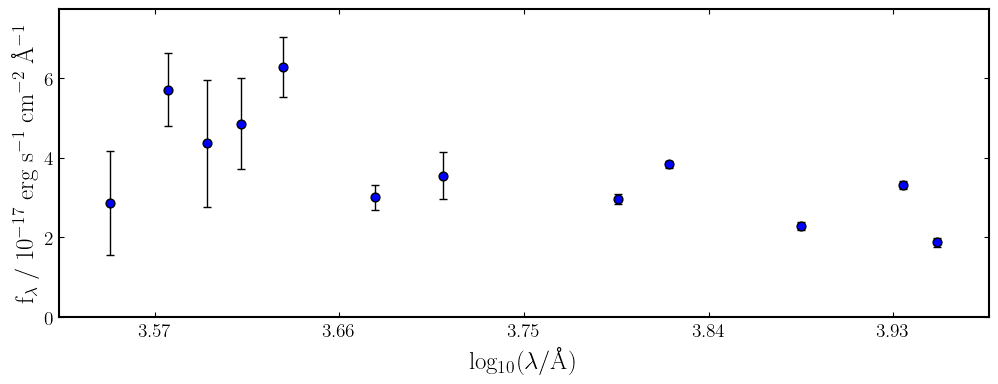


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    7
 *****************************************************

Completed in 157.8 seconds.
 ln(ev)=   424.57533600197206      +/-  0.24371518460146840     
 Total Likelihood Evaluations:        63055
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                 65.511     88.164    111.713
dblplaw:beta                 494.429    668.899    844.375
dblplaw:massformed             9.502      9.546      9.606
dblplaw:metallicity            1.112      1.261      1.412
dblplaw:tau                    9.647      9.697      9.732
dust:Av                   

/home/mousedesvio/miniconda3/lib/python3.13/site-packages/bagpipes/models/star_formation_history.py:278: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


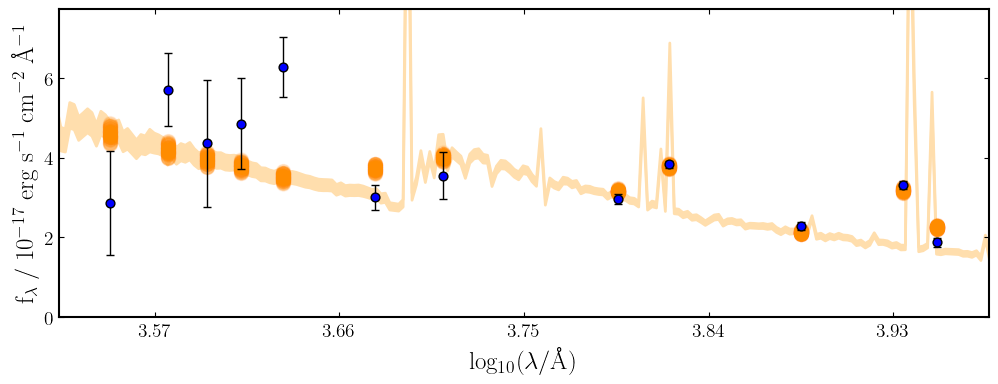

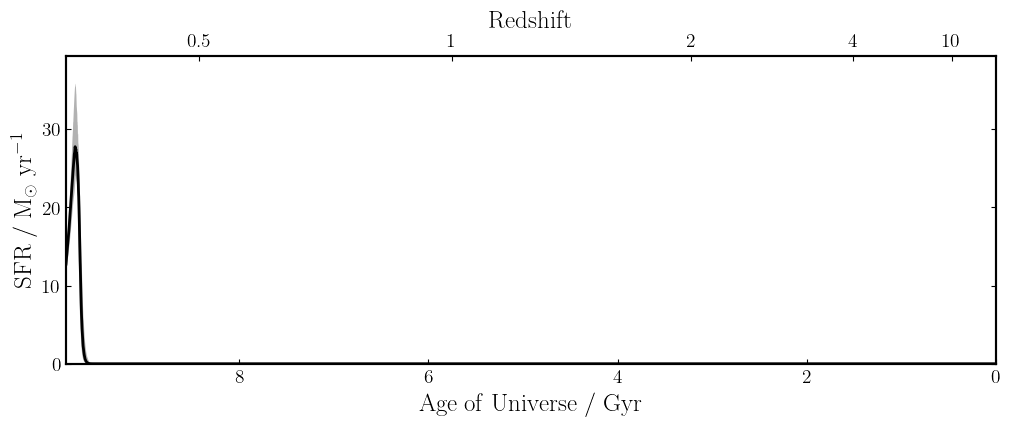

In [5]:
galaxy = bp.galaxy("1", load_Splus, spectrum_exists=False, filt_list=filter_list_splus, phot_units="mujy")
fig = galaxy.plot()

dblplaw = {}                        
dblplaw["tau"] = (0., 15.)                # Vary the time of peak star-formation between
                                          # the Big Bang at 0 Gyr and 15 Gyr later. In 
                                          # practice the code automatically stops this
                                          # exceeding the age of the universe at the 
                                          # observed redshift.
            
dblplaw["alpha"] = (0.01, 1000.)          # Vary the falling power law slope from 0.01 to 1000.
dblplaw["beta"] = (0.01, 1000.)           # Vary the rising power law slope from 0.01 to 1000.
dblplaw["massformed"] = (1., 15.)
dblplaw["metallicity"] = (0., 2.5)

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)
dust["eta"] = 2.

nebular = {}
nebular["logU"] = -3.

fit_instructions = {}
fit_instructions["redshift"] = (0., 1)
fit_instructions["dblplaw"] = dblplaw
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular

fit = bp.fit(galaxy, fit_instructions)

fit.fit(verbose=False)

fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)

This objects' information is 
ID: iDR4_FORNAX_RUN1_SPLUS-s24s39.24925
RA: 59.95472440034846
DEC: -30.359300768659708
Redshift: 0.31608164


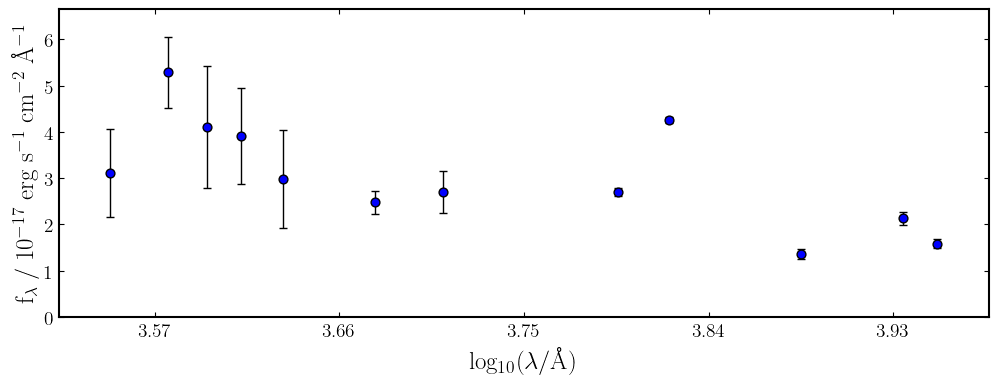


Bagpipes: fitting object 4

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************

Completed in 131.4 seconds.
 ln(ev)=   444.25051838635324      +/-  0.20783732458847246     
 Total Likelihood Evaluations:        50600
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.118      0.223      0.325
exponential:age                0.278      0.398      0.607
exponential:massformed         9.322      9.396      9.496
exponential:metallicity        0.231      0.340      0.459
exponential:tau                2.948      5.806      8.726
redshift                  

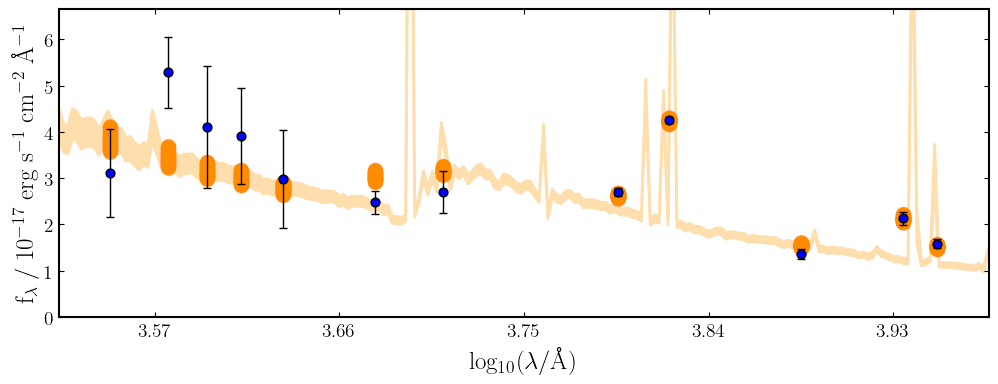

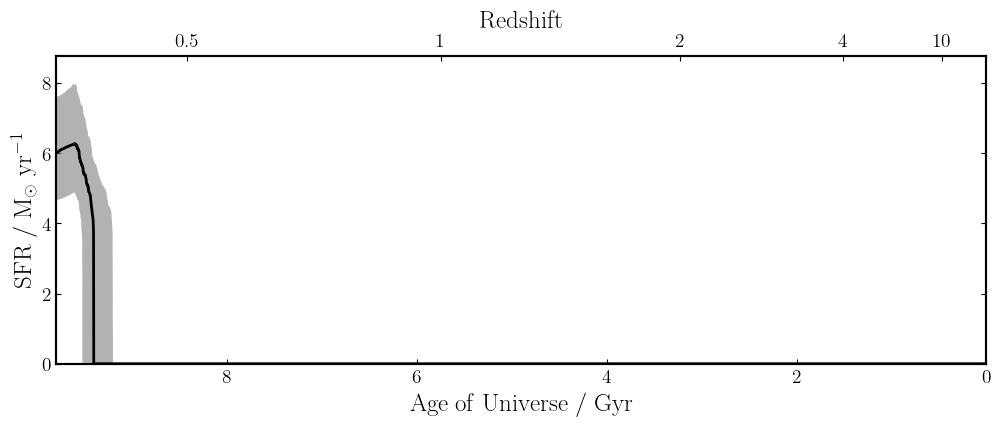

In [7]:
galaxy = bp.galaxy("4", load_Splus, spectrum_exists=False, filt_list=filter_list_splus, phot_units="mujy")
fig = galaxy.plot()

exp = {}
exp["age"] = (0.1, 15.)
exp["tau"] = (0., 10.)
exp["massformed"] = (0., 15.)
exp["metallicity"] = (0., 2.5)

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 2.)
dust["eta"] = 2.

nebular = {}
nebular["logU"] = -3.

fit_instructions = {}
fit_instructions["redshift"] = (0., 1)
fit_instructions["exponential"] = exp
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular

fit = bp.fit(galaxy, fit_instructions)

fit.fit(verbose=False)

fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)